In [5]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm


In [6]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    #Assumes degrees input
    #Calculates in metres
    R = 6371000 #Radius of earth in metres (roughly)
    ## Uses Haversine formula
    a1 = (sin((lat2_rad-lat1_rad)/2))**2
    a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
    a = a1 + a2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    d = R*c

    return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    #
    return floe_chord_lengths, floe_fb

def get_lead_width_position(leads_msk,seg_dist_x):
    lead_width = np.zeros(len(leads_msk)) # Making big enough array
    lead_position = np.zeros(len(leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    lead_idx = 1
    for i in range(1,len(leads_msk)):
        if (leads_msk[i] == 1) and (leads_msk[i-1] == 0): # start lead
            ice_cnt_st = i
            ice_cnt_en = i
        elif (leads_msk[i] == 1) and (leads_msk[i-1] == 1): # grow lead
            ice_cnt_en += 1
        elif (leads_msk[i-1] == 1) and (leads_msk[i] == 0): # stop lead
            lead_width[lead_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            lead_position[lead_idx] = (seg_dist_x[ice_cnt_en] + seg_dist_x[ice_cnt_st])/2
            lead_idx += 1
    #
    # Removing extra entries
    remove_idx = np.where(lead_width < 10)[0]  
    lead_position = np.delete(lead_position,remove_idx)
    lead_width = np.delete(lead_width,remove_idx)
    #
    return lead_width, lead_position

def get_lead_width_spacing_correlation(lead_widths,lead_positions,lead_width_bin_ranges):
    binned_lead_spacings = np.zeros(len(lead_width_bin_ranges)-1)
    binned_lead_count = np.zeros(len(lead_width_bin_ranges)-1)
    for i in range(len(lead_width_bin_ranges)-1):
        idx = np.where( (lead_widths >= lead_width_bin_ranges[i]) * (lead_widths < lead_width_bin_ranges[i+1]) )[0]
        spacings = np.abs(np.diff(lead_positions[idx]))
        if np.any(spacings):
            binned_lead_spacings[i] = np.mean(spacings)
            binned_lead_count[i] = len(idx) - 1 
    return binned_lead_count, binned_lead_spacings


In [7]:
# Getting lead statistics
path = 'data/ATL10/Weddell/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]
lead_width_bin_ranges = np.arange(10, 3000, 10)
lead_width_bin_means = 0.5*(lead_width_bin_ranges[0:-1] + lead_width_bin_ranges[1:])

# Looping through h5 files in directory
cnt_file = 0
for fname in filelist:
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)
    mth =  int(fname.split('_')[1][4:6])

    # Looping over beams. 
    # MG: CHANGE THIS TO ONLY INCLUDE STRONG BEAMS
    lead_positions = []
    lead_widths = []
    for beam in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:            
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        fb_height[fb_height > 30] = 0
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']
            
        # Creating binary array for: leads or spurious (0) / ice (1)
        height_segment_type = np.array(height_segment_type)
        leads_msk = 0*height_segment_type
        leads_msk[(height_segment_type <= 5)*(height_segment_type >= 2)] = 1

        # Getting lead widths and positions
        lead_width_tmp, lead_position_tmp = get_lead_width_position(leads_msk,seg_dist_x)

        # Appending to all strong-beams vectors
        lead_widths = np.append(lead_widths,lead_width_tmp)
        lead_positions = np.append(lead_positions,lead_position_tmp)
        
    # Getting binned lead count and spacing
    binned_lead_count, binned_lead_spacings = get_lead_width_spacing_correlation(lead_widths,lead_positions,lead_width_bin_ranges)

        
        


ATL10-02_20210203133757_06351001_005_01.h5
ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20

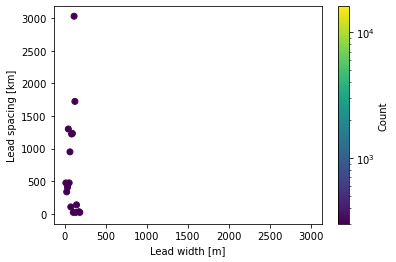

In [8]:
# Plotting lead statistics for one track
plt.scatter(lead_width_bin_means,binned_lead_spacings/1000, c = binned_lead_count, norm=colors.LogNorm(vmin=300, vmax=16000), cmap = 'viridis')
plt.xlabel('Lead width [m]')
plt.ylabel('Lead spacing [km]')
plt.colorbar(label='Count')
plt.savefig('plots/lead_width_spacing_correlation.pdf')  